# Initialize dataset path

In [ ]:
#import libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt # 2D plotting library
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.optimizers import Adam
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import requests
from PIL import Image
from io import BytesIO
import cv2  # image processing library
import pandas as pd
import numpy as np  # linear algebra
import os # used for loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# can change path to local directory if prefer.

Mounted at /content/drive


In [ ]:
fpath = "drive/My Drive/Colab Notebooks/ALL DATA/raw-img/"
translate = {"cane": "Dog", "cavallo": "Horse", "elefante": "Elephant", "farfalla": "Butterfly", "gallina": "Chicken", "gatto": "Cat", "mucca": "Cow", "pecora": "Sheep", "scoiattolo": "Squirrel", "ragno": "Spider"}

#Keras Image Data Generator

In [ ]:
#Creating Dataframe of images' path
foldernames = os.listdir(fpath)
files, files2, target, target2 = [], [], [], []

for i, folder in enumerate(foldernames):
    filenames = os.listdir(fpath+ folder);
    count = 0
    for file in filenames:
        # elephant has 1446 imges only. To maintain uniformty of counts among different classes, choose only first 1400 images
        if count < 1400:
            files.append(fpath + folder + "/" + file)
            target.append(translate[folder])
        else:
            files2.append(fpath + folder + "/" + file)
            target2.append(translate[folder])
        count += 1

df = pd.DataFrame({'Filepath':files, 'Target':target})
dft = pd.DataFrame({'Filepath':files2, 'Target':target2})
train, test = train_test_split(df, test_size=0.2857, random_state = 0)

In [ ]:
image_shape = (224,224,3)

In [ ]:
#create randomness to the training set
datagen = ImageDataGenerator(rescale=1./255,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              rotation_range=30, 
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              samplewise_center = True)

In [ ]:
datagen_test = ImageDataGenerator(rescale=1./255, samplewise_center = True)

In [ ]:
#training data
train_gen = datagen.flow_from_dataframe(train, 
                                        x_col = 'Filepath', 
                                        y_col = 'Target',
                                         target_size=image_shape[:2], 
                                        interpolation = 'lanczos', 
                                        validate_filenames = False)

Found 10000 non-validated image filenames belonging to 10 classes.


In [ ]:
#testing data
test_gen = datagen_test.flow_from_dataframe(test, 
                                             x_col = 'Filepath', 
                                             y_col = 'Target', 
                                             target_size=image_shape[:2], 
                                             interpolation = 'lanczos', 
                                             validate_filenames = False)

Found 4000 non-validated image filenames belonging to 10 classes.


#VGG 16 Model

In [ ]:
VGGmodel = VGG16(include_top=False, weights='imagenet', input_shape= image_shape)
# freeze the feature extractor values, as they're already pretrained on imagenet
# VGGmodel.trainable = False

# build the classificator model
flat = tf.keras.layers.Flatten()(VGGmodel.output)
dropout = Dropout(0.1)(flat)

# add hidden layer for classification
class1 = tf.keras.layers.Dense(256, activation='relu')(dropout)
dropout1 = Dropout(0.1)(class1)

# add the prediction layer
output = tf.keras.layers.Dense(10, activation='softmax')(dropout1)
VGGmodel = Model(inputs = VGGmodel.inputs, outputs = output)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, verbose = 1, min_delta=0.0001, min_lr = 1e-8)

VGGmodel.compile(loss='categorical_crossentropy', optimizer = optimizers.SGD(learning_rate=1e-3, momentum=0.9), metrics=['accuracy'])

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
VGGmodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
VGGhistory = VGGmodel.fit(train_gen, 
                    epochs = 10, 
                    validation_data = test_gen, 
                    callbacks=[ModelCheckpoint('VGG16.model', monitor='val_acc'), 
                    reduce_lr])

Epoch 1/10
313/313 [==============================] - 520s 2s/step - loss: 1.0490 - accuracy: 0.6360 - val_loss: 0.4128 - val_accuracy: 0.8715 - lr: 0.0010
Epoch 2/10
313/313 [==============================] - 358s 1s/step - loss: 0.4276 - accuracy: 0.8616 - val_loss: 0.3658 - val_accuracy: 0.8783 - lr: 0.0010
Epoch 3/10
313/313 [==============================] - 357s 1s/step - loss: 0.3120 - accuracy: 0.8970 - val_loss: 0.2260 - val_accuracy: 0.9330 - lr: 0.0010
Epoch 4/10
313/313 [==============================] - ETA: 0s - loss: 0.2532 - accuracy: 0.9155INFO:tensorflow:Assets written to: VGG16.model/assets

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
313/313 [==============================] - 359s 1s/step - loss: 0.2532 - accuracy: 0.9155 - val_loss: 0.2355 - val_accuracy: 0.9260 - lr: 0.0010
Epoch 5/10
313/313 [==============================] - 358s 1s/step - loss: 0.1291 - accuracy: 0.9606 - val_loss: 0.2012 - val_accuracy: 0.9460 - lr: 2.0000e

#Plotting Traning Accuracy (VGG 16)

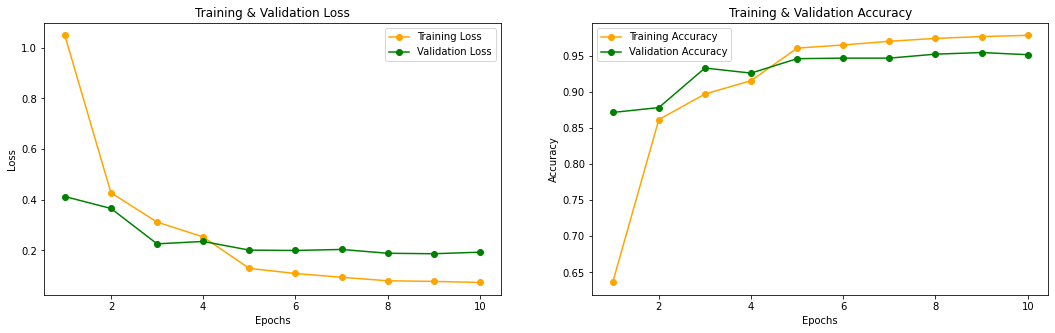

In [ ]:
loss_vals = VGGhistory.history['loss']
val_loss_vals = VGGhistory.history['val_loss']
epochs = range(1, len(VGGhistory.history['accuracy'])+1)

f, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,5))
    
ax[0].plot(epochs, loss_vals,  marker='o', color = 'orange', label='Training Loss')
ax[0].plot(epochs, val_loss_vals, marker='o', color = 'green', label='Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='best')

acc_vals = VGGhistory.history['accuracy']
val_acc_vals = VGGhistory.history['val_accuracy']

ax[1].plot(epochs, acc_vals, marker='o', color = 'orange', label='Training Accuracy')
ax[1].plot(epochs, val_acc_vals, marker='o', color = 'green', label='Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend(loc='best')

plt.show()

#Evaluation (VGG 16)

In [ ]:
test_flow = datagen_test.flow_from_dataframe(dft, 
                                             x_col = 'Filepath', 
                                             y_col = 'Target', 
                                             target_size=image_shape[:2],
                                             interpolation = 'lanczos', 
                                             validate_filenames = False)

Found 12179 non-validated image filenames belonging to 10 classes.


In [ ]:
score = VGGmodel.evaluate(test_flow)

381/381 [==============================] - 2201s 6s/step - loss: 0.2101 - accuracy: 0.9438


#Resnet50 Model

In [ ]:
Resnetmodel = ResNet50(include_top=False, weights='imagenet', input_shape= image_shape)
# freeze the feature extractor values, as they're already pretrained on imagenet
# Resnetmodel.trainable = False

# build the classificator model
flat = tf.keras.layers.Flatten()(Resnetmodel.output)
dropout = Dropout(0.1)(flat)

# add hidden layer for classification
class1 = tf.keras.layers.Dense(256, activation='relu')(dropout)
dropout1 = Dropout(0.1)(class1)

# add the prediction layer
output = tf.keras.layers.Dense(10, activation='softmax')(dropout1)
Resnetmodel = Model(inputs = Resnetmodel.inputs, outputs = output)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, verbose = 1, min_delta=0.0001, min_lr = 1e-8)

Resnetmodel.compile(loss='categorical_crossentropy', optimizer = optimizers.SGD(learning_rate=1e-3, momentum=0.9), metrics=['accuracy'])

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
Resnetmodel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
Resnethistory = Resnetmodel.fit(train_gen, 
                    epochs = 5, 
                    validation_data = test_gen, 
                    callbacks=[ModelCheckpoint('ResNet50transferlearning.model', monitor='val_acc'), 
                    reduce_lr])

Epoch 1/5
313/313 [==============================] - ETA: 0s - loss: 0.2822 - accuracy: 0.9099INFO:tensorflow:Assets written to: ResNet50transferlearning.model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


313/313 [==============================] - 1897s 6s/step - loss: 0.2822 - accuracy: 0.9099 - val_loss: 3.7801 - val_accuracy: 0.1055 - lr: 0.0010
Epoch 2/5
313/313 [==============================] - ETA: 0s - loss: 0.1886 - accuracy: 0.9396INFO:tensorflow:Assets written to: ResNet50transferlearning.model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


313/313 [==============================] - 359s 1s/step - loss: 0.1886 - accuracy: 0.9396 - val_loss: 0.7792 - val_accuracy: 0.7750 - lr: 0.0010
Epoch 3/5
313/313 [==============================] - ETA: 0s - loss: 0.1272 - accuracy: 0.9595INFO:tensorflow:Assets written to: ResNet50transferlearning.model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


313/313 [==============================] - 362s 1s/step - loss: 0.1272 - accuracy: 0.9595 - val_loss: 0.2506 - val_accuracy: 0.9337 - lr: 0.0010
Epoch 4/5
313/313 [==============================] - ETA: 0s - loss: 0.1022 - accuracy: 0.9670INFO:tensorflow:Assets written to: ResNet50transferlearning.model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


313/313 [==============================] - 364s 1s/step - loss: 0.1022 - accuracy: 0.9670 - val_loss: 0.2178 - val_accuracy: 0.9490 - lr: 0.0010
Epoch 5/5
313/313 [==============================] - ETA: 0s - loss: 0.0767 - accuracy: 0.9758INFO:tensorflow:Assets written to: ResNet50transferlearning.model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
313/313 [==============================] - 360s 1s/step - loss: 0.0767 - accuracy: 0.9758 - val_loss: 0.2573 - val_accuracy: 0.9430 - lr: 0.0010


#Plotting Traning Accuracy (Resnet 50)

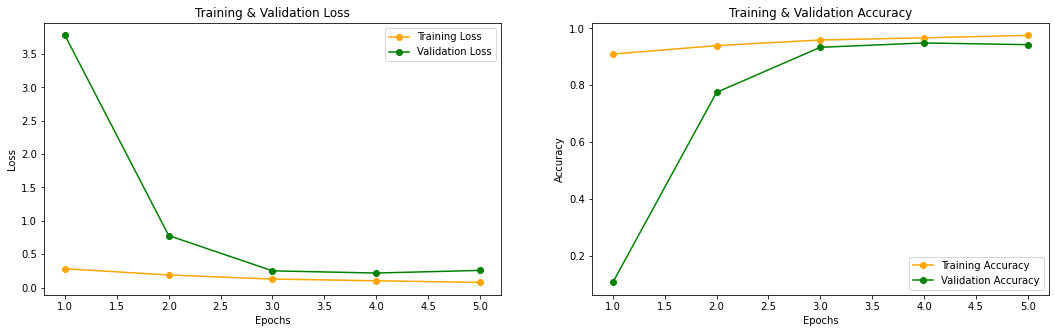

In [ ]:
loss_vals = Resnethistory.history['loss']
val_loss_vals = Resnethistory.history['val_loss']
epochs = range(1, len(Resnethistory.history['accuracy'])+1)

f, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,5))
    
ax[0].plot(epochs, loss_vals,  marker='o', color = 'orange', label='Training Loss')
ax[0].plot(epochs, val_loss_vals, marker='o', color = 'green', label='Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='best')

acc_vals = Resnethistory.history['accuracy']
val_acc_vals = Resnethistory.history['val_accuracy']

ax[1].plot(epochs, acc_vals, marker='o', color = 'orange', label='Training Accuracy')
ax[1].plot(epochs, val_acc_vals, marker='o', color = 'green', label='Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend(loc='best')

plt.show()

#Evaluation (Resnet 50)

In [ ]:
score = Resnetmodel.evaluate(test_flow)

381/381 [==============================] - 2251s 6s/step - loss: 0.2672 - accuracy: 0.9410


#Predication Image Setup

In [ ]:
img_url = ['https://kb.rspca.org.au/wp-content/uploads/2018/11/golder-retriever-puppy.jpeg',
           'https://nationaltoday.com/wp-content/uploads/2020/12/National-Horse-Day-1.jpg',
           'https://files.worldwildlife.org/wwfcmsprod/images/SQUARE_Bornean_pygmy_elephant_08.10.2012_Species/story_carousel/5zkg2r1pzk_HI_113471.jpg',
           'https://a-z-animals.com/media/2020/01/Butterfly-blue.jpg',
           'https://cdn.britannica.com/07/183407-050-C35648B5/Chicken.jpg',
           'https://cdn.mos.cms.futurecdn.net/VSy6kJDNq2pSXsCzb6cvYF-1200-80.jpg',
           'https://cdn-a.william-reed.com/var/wrbm_gb_food_pharma/storage/images/publications/feed/feednavigator.com/article/2020/05/19/the-cow-favors-natural-over-synthetic-vitamin-e/11403541-1-eng-GB/The-cow-favors-natural-over-synthetic-vitamin-E.jpg',
           'https://modernfarmer.com/wp-content/uploads/2017/12/Funny-Sheep-Facts-1200x800.jpg',
           'https://www.popsci.com/uploads/2021/08/05/pexels-skyler-ewing-7830065-scaled.jpg',
           'https://www.sciencenewsforstudents.org/wp-content/uploads/2021/09/1440_spider_feet_feat-1030x580.jpg',
          ]

In [ ]:
img_get = []
!mkdir Downloaded_Images
for i in range(len(img_url)):
    Image.open(BytesIO(requests.get(img_url[i]).content)).save("drive/My Drive/Colab Notebooks/ALL DATA/image" + str(i) + '.png')
    
# Load Images to array
new_images = []
for i in range(len(img_url)):
    temp = np.array(tf.keras.preprocessing.image.load_img( "drive/My Drive/Colab Notebooks/ALL DATA" + '/image' + str(i) + '.png', color_mode = "rgb", target_size = (224, 224), interpolation="lanczos")) / 255.0
    new_images.append(temp)
new_images = np.array(new_images)

mkdir: cannot create directory ‘Downloaded_Images’: File exists


#VGG 16

In [ ]:
# Store predictions in out
VGGpredictions = VGGmodel.predict(new_images)
pred_vgg = VGGpredictions.argmax(axis = -1)
out_vgg = []
for x in pred_vgg:
    labels = train_gen.class_indices
    for label, val in labels.items():
        if val == x:
            out_vgg.append(label)

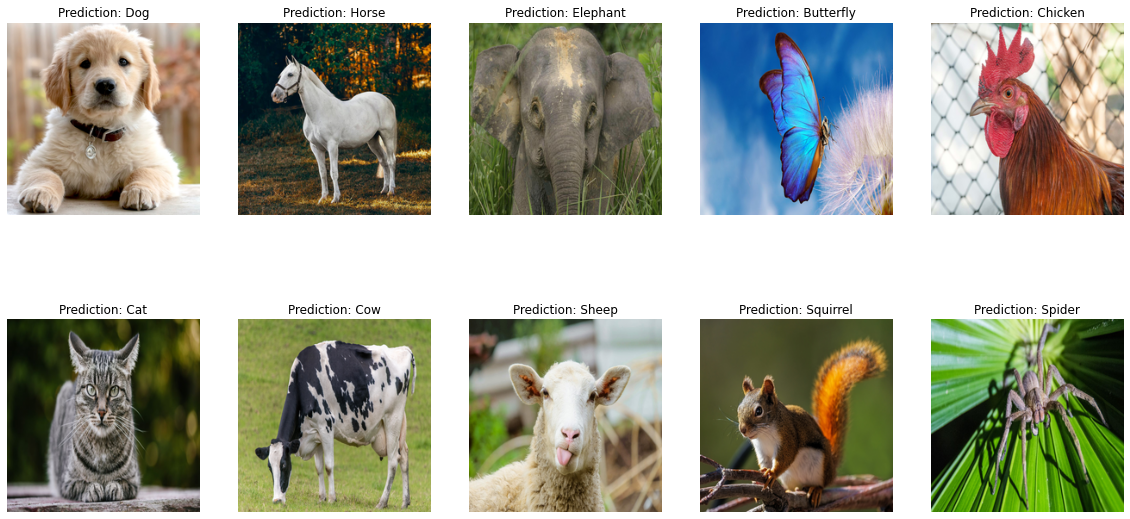

In [ ]:
# Print images and their predicitons

rows,cols = ((len(new_images) - 1) // 5 ) + 1,5
temp_axis = rows * 5
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,temp_axis))
for i in range(len(new_images)):
    temp = 'Prediction: ' + out_vgg[i]
    axes[i//cols, i%cols].set_title(temp)
    axes[i//cols, i%cols].axis('off')
    axes[i//cols, i%cols].imshow(new_images[i])

#Resnet 50

In [ ]:
# Store predictions in out
Resnetpredictions = Resnetmodel.predict(new_images)
pred_resnet = Resnetpredictions.argmax(axis = -1)
out_resnet = []
for x in pred_resnet:
    labels = train_gen.class_indices
    for label, val in labels.items():
        if val == x:
            out_resnet.append(label)

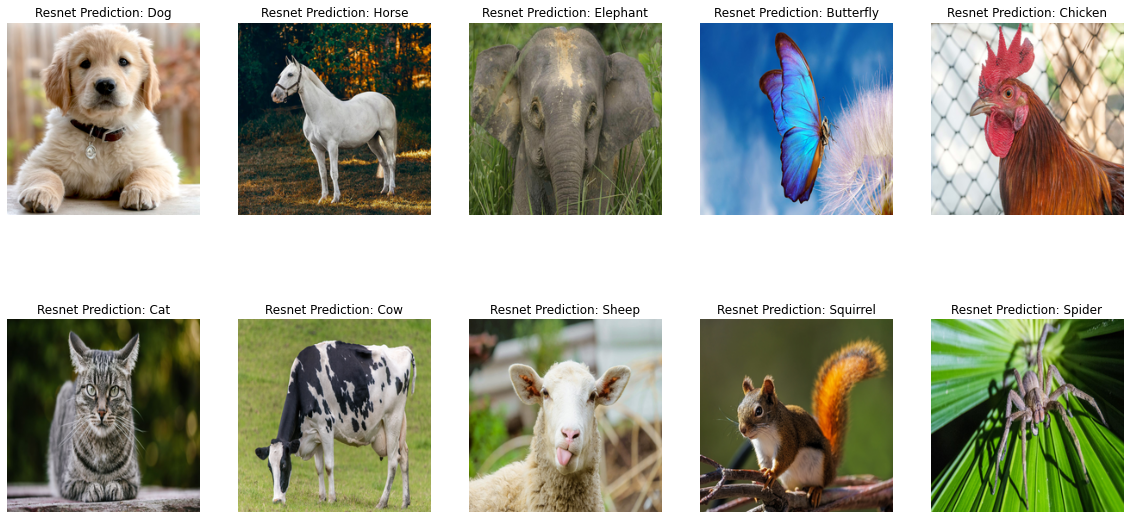

In [ ]:
# Print images and their predicitons

rows,cols = ((len(new_images) - 1) // 5 ) + 1,5
temp_axis = rows * 5
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,temp_axis))
for i in range(len(new_images)):
    temp = 'Resnet Prediction: ' + out_resnet[i]
    axes[i//cols, i%cols].set_title(temp)
    axes[i//cols, i%cols].axis('off')
    axes[i//cols, i%cols].imshow(new_images[i])